# Deep neural network model showcase

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE

from models import DeepNN

%matplotlib inline

### Data description and preprocesssing
#### Initial description

Plot densities (histograms) of some parameters to get an initial outlook on the data.

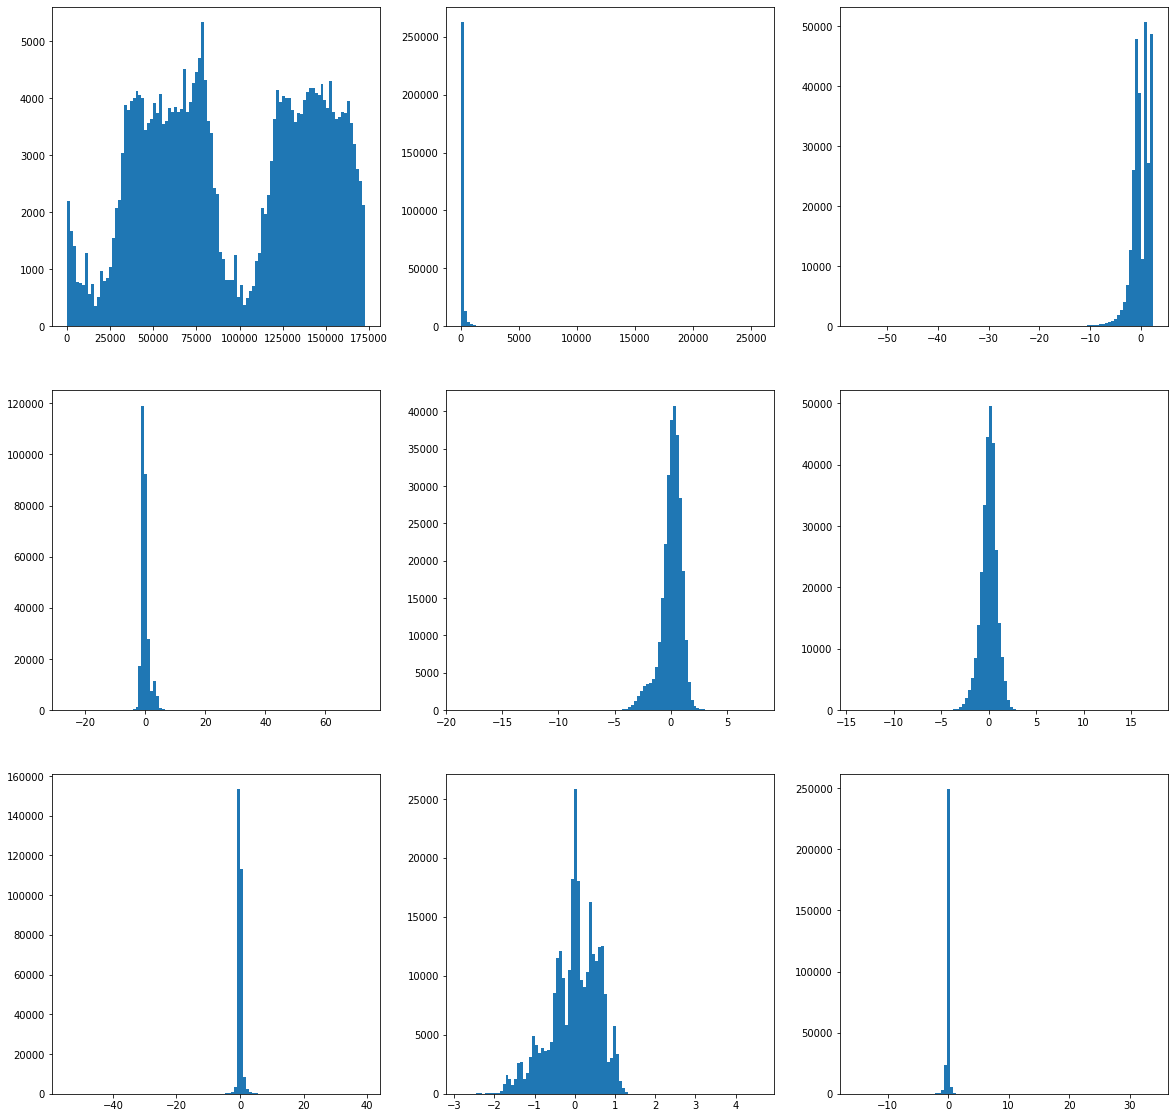

In [98]:
data_orig = pd.read_csv('dataset/creditcard.csv')
data_orig.dropna()

fig, axs = plt.subplots(3, 3, figsize=(20,20))
axs[0, 0].hist(data_orig['Time'], bins=100)
axs[0, 1].hist(data_orig['Amount'], bins=100)
axs[0, 2].hist(data_orig['V1'], bins=100)
axs[1, 0].hist(data_orig['V6'], bins=100)
axs[1, 1].hist(data_orig['V12'], bins=100)
axs[1, 2].hist(data_orig['V16'], bins=100)
axs[2, 0].hist(data_orig['V20'], bins=100)
axs[2, 1].hist(data_orig['V24'], bins=100)
axs[2, 2].hist(data_orig['V28'], bins=100)
plt.show()

As we can see, some parameters resemble normal distribution. Although, there's no difference for our model which distribution is it. It's just good to know this when we will be normalizing these.

#### Distribution of classes and balancing

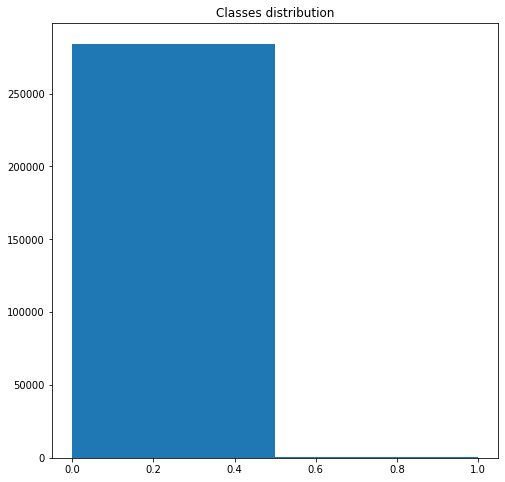

In [99]:
plt.figure(figsize=(8,8))
plt.hist(x=data_orig['Class'], bins=2)
plt.title('Classes distribution')
plt.show()

As we can see, the data is colossaly imbalanced. This is a problem, at least because with such a dataset correlations between parameters is difficult to detect:

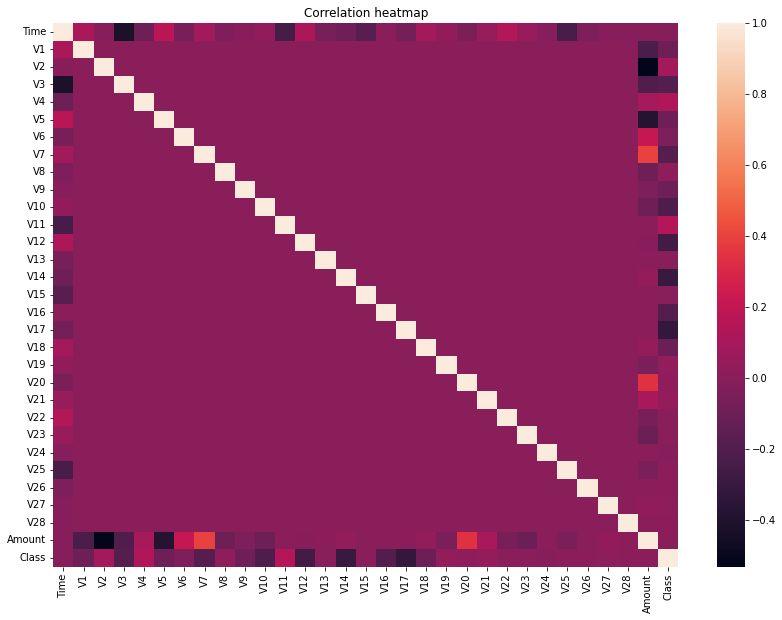

In [100]:
plt.figure(figsize=(14,10))
sns.heatmap(data=data_orig.corr())
plt.title('Correlation heatmap')
plt.show()

To solve this issue, let us use undersampling and oversampling to balance the dataset. But first let us split dataset into train and validation datasets, so the test dataset will be an unbiased estimator for our model's accuracy.

In [101]:
fraud_df = data_orig.loc[data_orig['Class'] == 1]
non_fraud_df = data_orig.loc[data_orig['Class'] == 0]
train_fraud, test_fraud = np.split(fraud_df, [int(0.8*len(fraud_df))])
train_nonfraud, test_nonfraud = np.split(non_fraud_df, [int(0.8*len(non_fraud_df))])
train_df = pd.concat([train_fraud, train_nonfraud])

Undersample test dataset, so it won't be imbalanced or contain biases.

c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


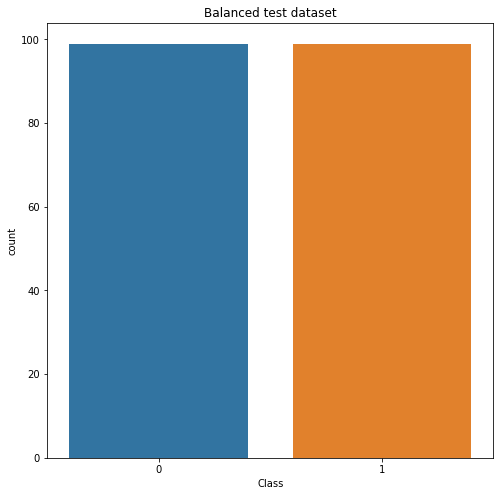

In [102]:
test_nonfraud = test_nonfraud.sample(n=len(test_fraud), random_state=42)
test_df = pd.concat([test_fraud, test_nonfraud])
test_df = test_df.sample(frac=1, random_state=3)

plt.figure(figsize=(8,8))
sns.countplot('Class', data=test_df)
plt.title("Balanced test dataset")
plt.show()

Then, resample train dataset. To oversample, use SMOTE algorithm from imblearn.

c:\Users\dimon\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


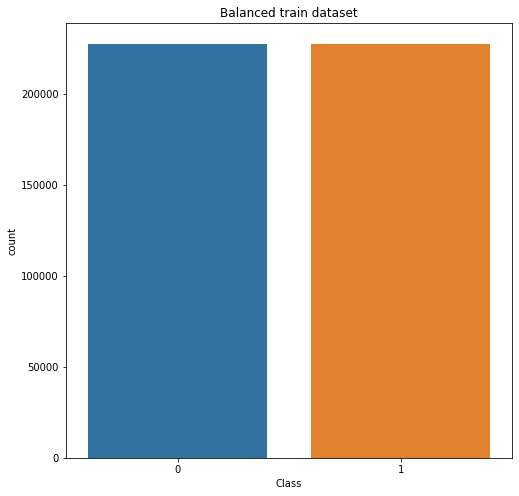

In [103]:
sm = SMOTE(sampling_strategy='minority', random_state=7)
oversampled_trainX, oversampled_trainY = sm.fit_resample(train_df.drop('Class', axis=1), train_df['Class'])
train_df = pd.concat([pd.DataFrame(oversampled_trainX), pd.DataFrame(oversampled_trainY)], axis=1)
train_df = train_df.sample(frac=1, random_state=4)

plt.figure(figsize=(8,8))
sns.countplot('Class', data=train_df)
plt.title("Balanced train dataset")
plt.show()

Now, we can observe correlations between some of the variables:

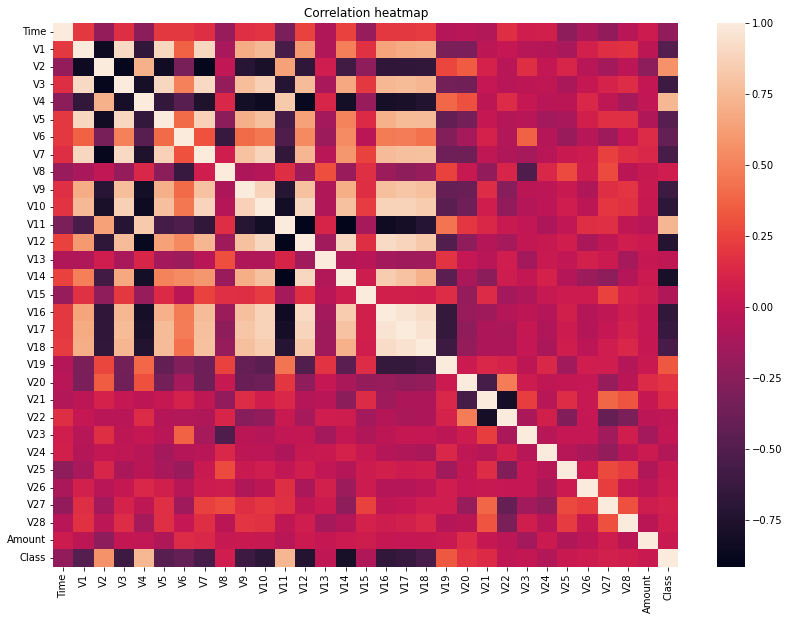

In [104]:
plt.figure(figsize=(14,10))
sns.heatmap(data=train_df.corr())
plt.title('Correlation heatmap')
plt.show()

Then, convert dataframes to numpy arrays since our model will be working with them.

In [105]:
train_Y = train_df['Class'].to_numpy().reshape((1, -1))
test_Y = test_df['Class'].to_numpy().reshape((1, -1))
train_df = train_df.drop('Class', axis=1)
test_df = test_df.drop('Class', axis=1)
train_X = train_df.transpose().to_numpy()
test_X = test_df.transpose().to_numpy()

# Check the shapes
print(train_Y.shape)
print(test_Y.shape)
print(train_X.shape)
print(test_X.shape)

(1, 454904)
(1, 198)
(30, 454904)
(30, 198)


#### Data normalization
That's a common practice to normalize data while training the network. In such a way, training process will be faster and, in some cases, we can obtain greater accuracy.

In [106]:
eps = 0.0001
means_test = np.mean(test_X, axis=1, keepdims=True)
means_train = np.mean(train_X, axis=1, keepdims=True)
std_test = np.std(test_X, axis=1, keepdims=True)
std_train = np.std(train_X, axis=1, keepdims=True)

test_X = (test_X - means_test) / (std_test + eps)
train_X = (train_X - means_train) / (std_train + eps)

print(train_X.shape)
print(test_X.shape)
print(test_X)
print(train_X)

(30, 454904)
(30, 198)
[[-0.3427324  -0.69149126  1.87533492 ... -0.13325774  1.51682739
   0.15591233]
 [-1.47578576 -0.31316635 -0.28571618 ...  1.23642598  1.07830291
  -0.03023112]
 [ 1.37599658 -0.36980937 -0.28653562 ... -1.0307961  -0.54337645
  -0.1080354 ]
 ...
 [-4.0959293  -0.07873998  0.01370056 ... -0.07023929 -0.04620528
  -0.24112257]
 [ 1.03806293  0.2369034  -0.48398133 ... -0.3128642  -0.32393664
  -0.01237945]
 [-0.43356921 -0.43356921  0.46406281 ... -0.36649704 -0.3205784
   1.21274302]]
[[ 1.08361418 -0.78503627  0.30227017 ...  0.21121521  0.12909079
  -1.63185283]
 [ 0.83854815  0.36915437  0.34398914 ...  0.69832057  0.69539352
   0.27053606]
 [-0.56863728 -0.30368051 -0.40589607 ... -0.52028767 -0.61988776
   0.57040836]
 ...
 [-0.07665204  0.29211278  0.20329205 ... -0.10117065 -0.07388554
   0.76878062]
 [-0.20077826  0.30520679  0.18986058 ... -0.03369907 -0.01415446
   1.04586303]
 [-0.43812885 -0.4368123  -0.41996957 ... -0.43367982 -0.39046074
  -0.43812

### Training and validating model

We'll use basic neural network with dense layers. The archecture will be the following [30, 24, 16, 12, 8, 4, 1], where each value of the list is a number of neurons on each layer. Note that the first (input) layer has 30 neurons - the number of feautures in our data, and last (output) layer has a single value between 0 and 1.

In [111]:
model = DeepNN(train_X, train_Y, test_X, test_Y, [30, 24, 16, 12, 8, 4, 1])
model.load_params('model3.json')

Then, validate...

In [112]:
model.train_validate()
model.validate()

train accuracy: 98.55354096688532 %
test accuracy: 92.92929292929293 %


array([[1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0.,
        1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
        1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0.]])